<a href="https://colab.research.google.com/github/saicharan-r/Erav1/blob/main/S7/S7-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
%cd /content/drive/MyDrive/Erav1/S7

/content/drive/MyDrive/Erav1/S7


In [66]:
%pip install torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
from models import Model_3 as Net

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)


In [68]:
train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)


In [69]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

In [71]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(model,input_size=(batch_size, 1, 28, 28))

cuda


In [72]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
        )
        train_acc.append(100 * correct / processed)

    # epoch accuracy = accuracy for the whole batch
    epoch_train_acc.append(100 * correct / processed)
    return 100 * correct / processed


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))


In [73]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=0)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    accuracy = train(model, device, train_loader, optimizer, epoch)
    scheduler.step(accuracy)
    test(model, device, test_loader)

EPOCH: 0


LR=0.3 Loss=0.0787350982427597 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:30<00:00, 15.28it/s]


Test set: Average loss: 0.0654, Accuracy: 9797/10000 (97.97%)

EPOCH: 1


LR=0.3 Loss=0.1105835810303688 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:24<00:00, 19.41it/s]


Test set: Average loss: 0.0569, Accuracy: 9821/10000 (98.21%)

EPOCH: 2


LR=0.3 Loss=0.04985371604561806 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]


Test set: Average loss: 0.0453, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


LR=0.3 Loss=0.058404501527547836 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Test set: Average loss: 0.0457, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


LR=0.3 Loss=0.022256551310420036 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:22<00:00, 20.75it/s]


Test set: Average loss: 0.0335, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


LR=0.3 Loss=0.0022007205989211798 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]


Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


LR=0.3 Loss=0.06486895680427551 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


LR=0.03 Loss=0.023268787190318108 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


LR=0.03 Loss=0.021380333229899406 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


LR=0.03 Loss=0.07346095889806747 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:23<00:00, 19.97it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


LR=0.003 Loss=0.004938425961881876 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


LR=0.003 Loss=0.057651374489068985 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


LR=0.003 Loss=0.004815695341676474 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]


Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


LR=0.00030000000000000003 Loss=0.015988105908036232 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


LR=3.0000000000000004e-05 Loss=0.011227831244468689 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

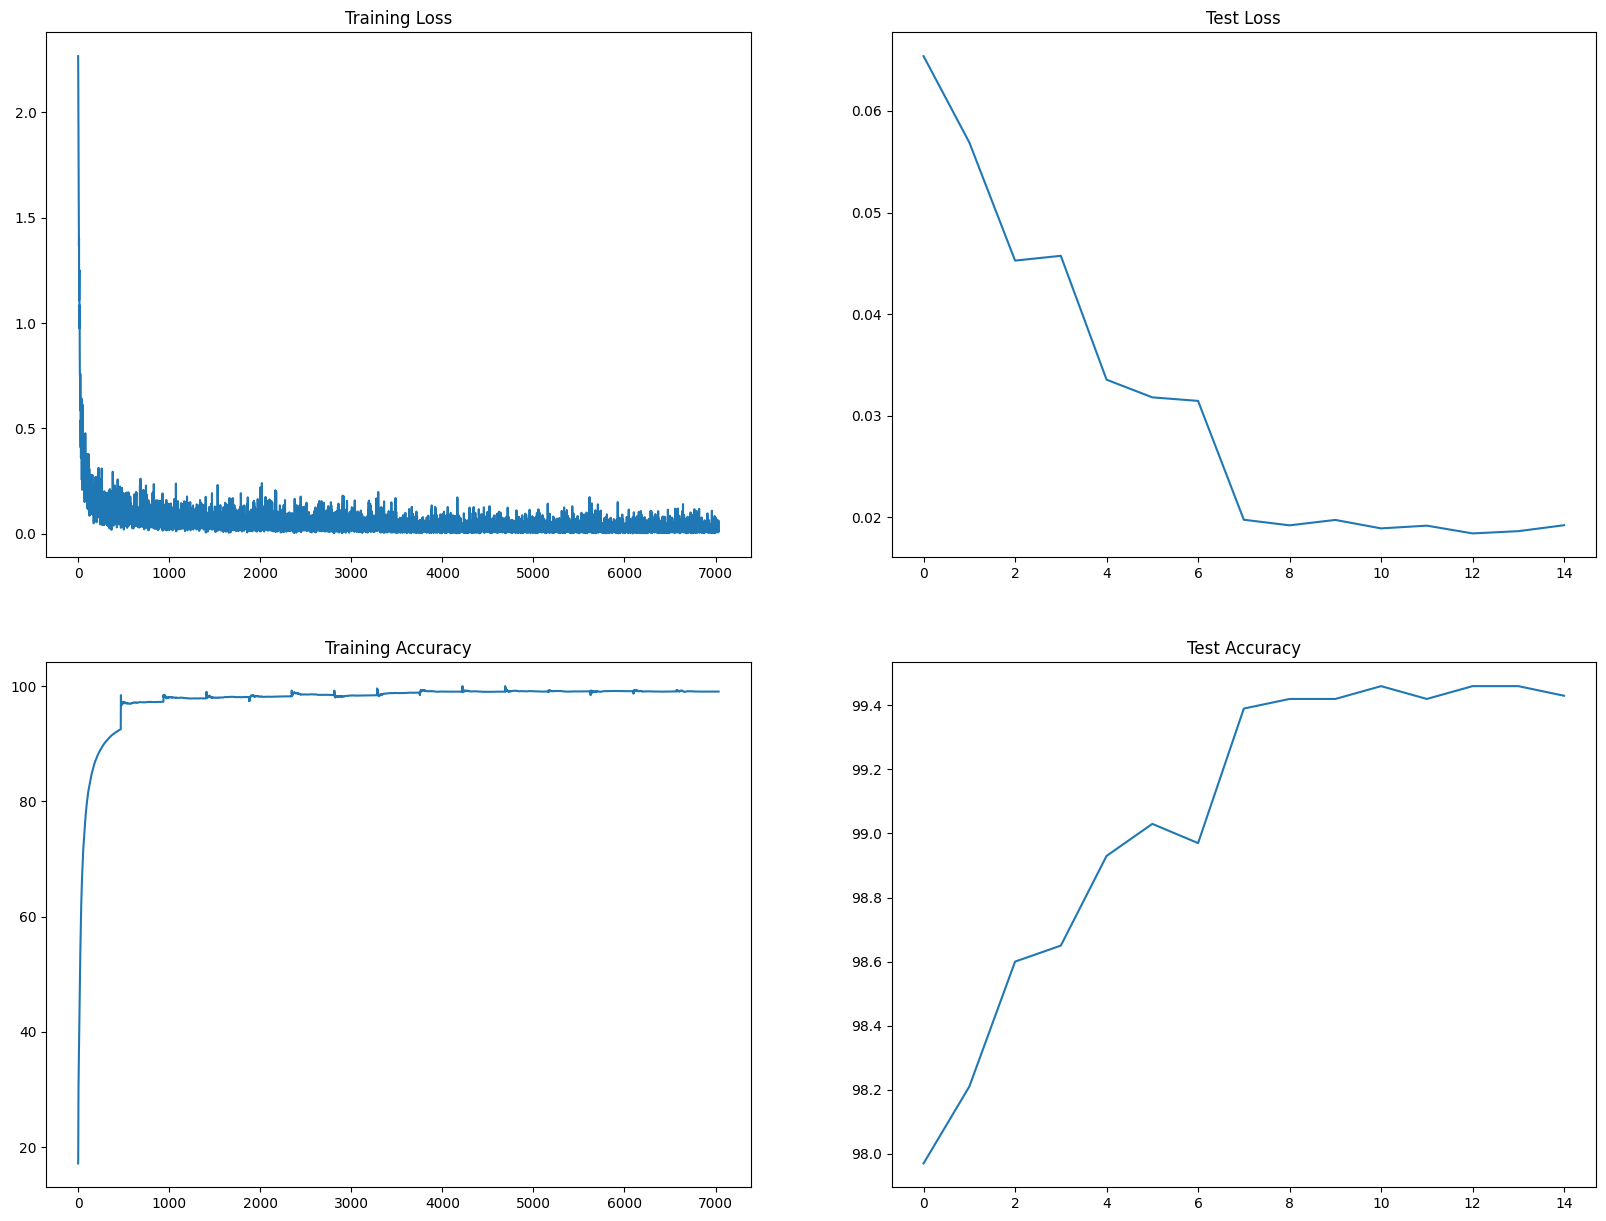

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")